<a href="https://colab.research.google.com/github/surajsrivathsa/ovgu_deeplearning/blob/master/Introspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Assignment 4:** Introspection

**Team members:**
1. Sanjeeth Busnur Indushekar: 224133 : sanjeeth.busnur@st.ovgu.de
2. Suraj Shashidhar: 230052 : suraj.shashidhar@st.ovgu.de

Tasks To be done

4.1 gradient-based saliency map (sensitivity analysis)

- - Run a batch of inputs through the trained model.

Wrap this in a GradientTape where you watch the input batch.
(batch size can be 1 if you just like to produce a single saliency map)
Compute the gradient for a particular logit or its softmax output with respect to the input.

- This tells us how a change in each input pixel would affect the class output.

- This already gives you a batch of gradient-based saliency maps!

- Plot the saliency map next to the original image or superimpose it.

- Do the saliency maps seem to make sense? How would you interpret them?

Hint: It makes sense to take the sign of the gradient into account when interpreting them.

Negative gradients indicate a decrease in output value, positive gradients an increase.

4.2 Activation Maximization

Extend the code from 4.1 to create an optimal input for a particular class.

- Add the gradients (i.e. the saliency map) to the input. You should multiply the gradients with a small constant (like a learning rate) to make sure the inputs aren’t changed too much.

- Do multiple update steps to make the input more optimal for the chosen output class.
(I recommend implementing your own update step, but you are allowed to use a keras training loop to optimize the input.)

- Does the resulting input look natural?

- How does the inputs change when applying many steps of optimization?

- How do the optimal inputs differ when initializing the optimization with random noise instead of real examples?

Bonus: Apply regularization strategies to make the optimal input more natural-looking.



In [1]:
import os
%tensorflow_version 2.x
import tensorflow as tf
from sklearn import preprocessing
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import copy
import numpy as np
from datasets import MNISTDataset

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import initializers
import tensorboard
import time
from datetime import datetime
from keras import backend as K

In [3]:
print('tensorflow {}'.format(tf.__version__))
print("keras {}".format(keras.__version__))

tensorflow 2.3.0
keras 2.4.0


11493376/11490434 [==============================] - 0s 0us/step
[0 4 1 9 2 1 3 1 4]


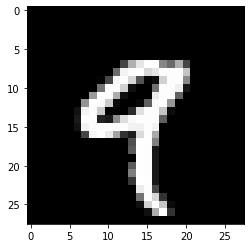

In [4]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
plt.imshow(train_images[4], cmap="Greys_r")
print(train_labels[1:10])

In [5]:
data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)
print(train_images.reshape([-1, 784]).shape)

(60000, 784)


In [6]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [ ]:
new_train_images = tf.cast(tf.expand_dims(train_images, axis = -1),dtype="float32")
print(new_train_images.shape)

new_test_images = tf.cast(tf.expand_dims(test_images, axis=-1 ),dtype="float32")
print(new_test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [7]:
introspection_training_images = tf.cast(tf.expand_dims(train_images, axis = -1),dtype="float32")
introspection_testing_images = tf.cast(tf.expand_dims(test_images, axis=-1 ),dtype="float32")

introspection_training_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
introspection_testing_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

# Pretrain a simple CNN model

In [ ]:
def create_cnn_model():
  model = keras.Sequential()
  model.add(layers.Conv2D(filters=8,kernel_size=(3,3),padding="same",activation="relu" , input_shape=(28, 28, 1), ))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding="same",activation="relu" ))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
  model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
  model.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
  model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=64,kernel_size=(1,1),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten(input_shape=(3,3,64)))
  model.add(layers.Dense(units=256, activation="relu"))
  model.add(layers.Dense(units=10,activation="softmax"))
  model.summary()
  return model;

In [ ]:
vgg_cnn_model = create_cnn_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 8)         32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        1

In [ ]:
vgg_cnn_model.compile(optimizer="adam", loss = tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

In [ ]:
vgg_cnn_model.fit(new_train_images, train_labels,  epochs=3, batch_size=128, validation_data= (new_test_images, test_labels))

Epoch 1/3
469/469 [==============================] - 5s 11ms/step - loss: 0.1188 - accuracy: 0.9636 - val_loss: 0.0642 - val_accuracy: 0.9797
Epoch 2/3
469/469 [==============================] - 5s 10ms/step - loss: 0.0348 - accuracy: 0.9891 - val_loss: 0.0317 - val_accuracy: 0.9904
Epoch 3/3
469/469 [==============================] - 5s 10ms/step - loss: 0.0269 - accuracy: 0.9919 - val_loss: 0.0397 - val_accuracy: 0.9884


In [ ]:
vgg_cnn_model.save("/content/vgg_cnn_model_introspection")

INFO:tensorflow:Assets written to: /content/vgg_cnn_model_introspection/assets


In [ ]:
!zip -r vgg_cnn_model_introspection.zip /content/vgg_cnn_model_introspection

  adding: content/vgg_cnn_model_introspection/ (stored 0%)
  adding: content/vgg_cnn_model_introspection/saved_model.pb (deflated 91%)
  adding: content/vgg_cnn_model_introspection/variables/ (stored 0%)
  adding: content/vgg_cnn_model_introspection/variables/variables.data-00001-of-00002 (deflated 8%)
  adding: content/vgg_cnn_model_introspection/variables/variables.index (deflated 75%)
  adding: content/vgg_cnn_model_introspection/variables/variables.data-00000-of-00002 (deflated 83%)
  adding: content/vgg_cnn_model_introspection/assets/ (stored 0%)


# Saliency Maps

This is the side by side comparision of images with mask of number one applied.

**Process**

- Predict the softmax output of the model.

- Apply mask on softmax/logits output. For example if we want to find the output number ones contribution or sensitivity then except number one softmax make everything zero, same way do for other numbers separately. Hence we end up with 10 masks.

- Apply these masks on softmax output and find the losses. Obviously losses will be high for most of the numbers as we have masked the relvenat part of softmax out

- Backpropagate and now find the derivative of masked softmax wrt input image, Since all softmax output positions except one position is zero gradient can only flow back through this position.

- This is not guided backprop as we are not applying subsequent relu masks on intermeditate layers featuremaps but only on output.

- At the end get the gradients and plot them side by side wrt to input image

**Sensitivity analysis for number 1**

- We can see that numbers **6, 8, 0** which doesn't have stick shape has no bearing or contribution of softmax(even a little softmax of one is not present in these numbers). S**o these numbers are insensitive to the number one.**

- For some numbers like **3, 9 and 4** we can see a slight presence of one when the numbers are slanted. **Less sensitivity**

- For number **7** the presence of softmax ones contribution can be clearly seen especially at last image. **Some sensitivity.**

- **For contribution of one to one itself, we can see some strong sensitivity.** But thing to note here is for the second one(the one in 3rd row which is really straight and not slant) **it is surprising to see that one is getting recognized due to sensitivity of irrelvenat pixels rather the stick like figure, for one that are slant the activations are from stick.** **Same pattern is present in 7 too if we can see at the last 7 where slnated 7 is getting recognized.**

- **This clearly demonstrates that CNN based detection models are non-human like, even though we think them to be. Even after 50 - 60k examples CNN was not able to learn the context better than humans where humans have lower resolution than machines. This is a clear demonstration that we need Better models than CNNs in the future**.

**Sensitivity analysis for number 8**

- Surprisingly number 1 and 7 which are least related to number 8 are getting activated. Seems like slanted stick like pattern is getting activated everytime.

- Numbers 9 are getting activated which are no surprise as upper part of 9 looks like a half of 8. But 9 was activated mainly due to its lower part and garbage pixels. which raises doubts on ability of CNN to understand semantic meaning of images.

- 3 should have been activated as it looks like a half of 8, but it dod not happen.

In [8]:
!unzip "/content/vgg_cnn_model_introspection.zip" 

Archive:  /content/vgg_cnn_model_introspection.zip
   creating: content/vgg_cnn_model_introspection/
  inflating: content/vgg_cnn_model_introspection/saved_model.pb  
   creating: content/vgg_cnn_model_introspection/variables/
  inflating: content/vgg_cnn_model_introspection/variables/variables.data-00001-of-00002  
  inflating: content/vgg_cnn_model_introspection/variables/variables.index  
  inflating: content/vgg_cnn_model_introspection/variables/variables.data-00000-of-00002  
   creating: content/vgg_cnn_model_introspection/assets/


In [9]:
vgg_cnn_model = keras.models.load_model(filepath="/content/content/vgg_cnn_model_introspection")


In [10]:
vgg_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 8)         32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        1

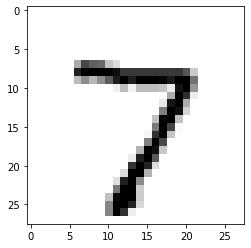

In [11]:
introspection_image = introspection_testing_images[0, :, :, :]
plt.imshow(introspection_image[:, :, 0], cmap="binary")

In [12]:
introspection_prediction = vgg_cnn_model.predict(introspection_testing_images[0:8, :, :, :])
introspection_prediction.shape

(8, 10)

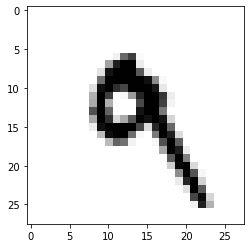

In [13]:
plt.imshow(introspection_testing_images[7,:,:,0], cmap="binary")

In [14]:
introspection_prediction[7]

array([7.5519985e-08, 2.8737236e-06, 5.9842296e-07, 2.4699690e-07,
       4.1525485e-03, 2.5558572e-06, 4.9045508e-07, 1.7699102e-07,
       8.8364504e-06, 9.9583167e-01], dtype=float32)

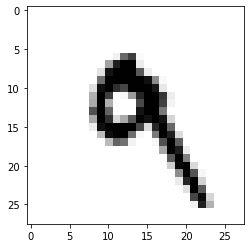

In [15]:
plt.imshow(introspection_testing_images[7, :, :, 0], cmap="binary")

In [16]:
zero_mask = tf.tile(tf.Variable(initial_value=tf.constant([1,0,0,0,0,0,0,0,0,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
one_mask =  tf.tile(tf.Variable(initial_value=tf.constant([0,1,0,0,0,0,0,0,0,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
two_mask =  tf.tile(tf.Variable(initial_value=tf.constant([0,0,1,0,0,0,0,0,0,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
three_mask = tf.tile(tf.Variable(initial_value=tf.constant([0,0,0,1,0,0,0,0,0,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
four_mask =  tf.tile(tf.Variable(initial_value=tf.constant([0,0,0,0,1,0,0,0,0,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
five_mask =  tf.tile(tf.Variable(initial_value=tf.constant([0,0,0,0,0,1,0,0,0,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
six_mask = tf.tile(tf.Variable(initial_value=tf.constant([0,0,0,0,0,0,1,0,0,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
seven_mask = tf.tile(tf.Variable(initial_value=tf.constant([0,0,0,0,0,0,0,1,0,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
eight_mask =  tf.tile(tf.Variable(initial_value=tf.constant([0,0,0,0,0,0,0,0,1,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
nine_mask =  tf.tile(tf.Variable(initial_value=tf.constant([0,0,0,0,0,0,0,0,0,1], dtype="float32", shape=(1,10))) , multiples=[10000,1])




In [71]:

def record_tape(introspection_testing_images, introspection_testing_labels, mask_list=[zero_mask]):
  with tf.GradientTape() as tape:
    tape.watch(introspection_testing_labels)
    tape.watch(introspection_testing_images)
    introspection_prediction = vgg_cnn_model(introspection_testing_images)
    print(introspection_prediction.shape)
    masked_output = []
    masked_loss = []

    # We need to find the loss only wrt one logits, hence set all the other logits output to zero by multiplying with binary mask
    for msk in mask_list:
      masked_output.append(tf.multiply(msk, introspection_prediction))

    #zero_position_output = tf.multiply(zero_mask,introspection_prediction)
    #ones_position_output = tf.multiply(one_mask,introspection_prediction)
    
    #Not used anywhere, just there for simple cross check
    complete_loss = tf.keras.losses.sparse_categorical_crossentropy(introspection_testing_labels, introspection_prediction)
    

    #masked loss corresponding to the each masked output
    """
    For example: if picture is of number 5 and mask of 5 is applied then every position except 5 is made zero so gradient doesn't flow back.
    , for mask of any other number we have higher losss as it doesn't correspond to 5.
    Loss will be high for other numbers than picture
    """
    for msk_op in masked_output:
      masked_loss.append(tf.keras.losses.sparse_categorical_crossentropy(introspection_testing_labels, msk_op))

    #ones_grad_loss = tf.keras.losses.sparse_categorical_crossentropy(test_labels,ones_position_output)

  return [tape, masked_loss];

#grads = tape.gradient(zero_grad_loss,introspection_testing_images)


In [72]:
tape, masked_loss = record_tape(introspection_testing_images, introspection_testing_labels, mask_list=[one_mask])

(10000, 10)


In [73]:
def calculate_masked_grads(introspection_testing_images, introspection_testing_labels, tape, masked_loss):
  masked_grads = []

  for msk_loss in masked_loss:
    masked_grads.append(tape.gradient(msk_loss,introspection_testing_images))
  
  return masked_grads;

In [74]:
masked_grads = calculate_masked_grads(introspection_testing_images, introspection_testing_labels, tape, masked_loss)

In [75]:
masked_grads[0].shape

TensorShape([10000, 28, 28, 1])

In [ ]:
masked_grads[0][2,:,:,:]

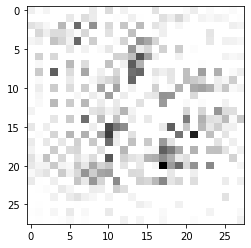

In [31]:
plt.imshow(tf.nn.relu(masked_grads[0][2,:,:,0]), cmap = "binary")

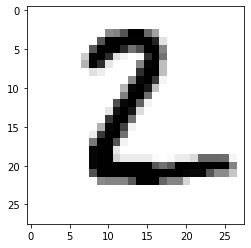

In [69]:
plt.imshow(introspection_testing_images[1,:,:,0], cmap = "binary")

In [81]:
def plot_figures(introspection_testing_images, masked_grads, num_images=25):
  x_subplots = tf.math.sqrt(tf.constant(num_images, dtype = tf.float32))
  plt.figure(figsize=(10,10))
  j = -1
  for i in range(0, num_images):
      plt.subplot(6, 6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      j = j + 1
      if(i % 2 == 0):  
        plt.imshow(introspection_testing_images[i, :, :, 0], cmap=plt.cm.binary)
        #print(i)
      elif(j%2 == 1):      
        plt.imshow(tf.nn.relu(masked_grads[0][j-1, :, :, 0]), cmap="Greys_r")
        #print(j-1)
      
      #plt.xlabel(class_names[test_images[i]])
  plt.show()

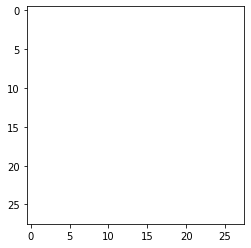

In [67]:
plt.imshow(masked_grads[0][8, :, :, 0], cmap=plt.cm.binary)

This is the side by side comparision of images with mask of number one applied

- We can see that numbers **6, 8, 0** which doesn't have stick shape has no bearing or contribution of softmax(even a little softmax of one is not present in these numbers). S**o these numbers are insensitive to the number one.**

- For some numbers like **3, 9 and 4** we can see a slight presence of one when the numbers are slanted. **Less sensitivity**

- For number **7** the presence of softmax ones contribution can be clearly seen especially at last image. **Some sensitivity.**

- **For contribution of one to one itself, we can see some strong sensitivity.** But thing to note here is for the second one(the one in 3rd row which is really straight and not slant) **it is surprising to see that one is getting recognized due to sensitivity of irrelvenat pixels rather the stick like figure, for one that are slant the activations are from stick.** **Same pattern is present in 7 too if we can see at the last 7 where slnated 7 is getting recognized.**

- **This clearly demonstrates that CNN based detection models are non-human like, even though we think them to be. Even after 50 - 60k examples CNN was not able to learn the context better than humans where humans have lower resolution than machines. This is a clear demonstration that we need Better models than CNNs in the future**.

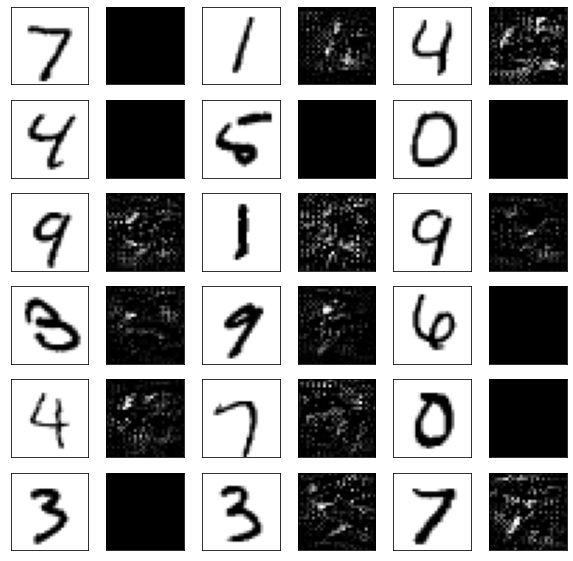

In [82]:
plot_figures(introspection_testing_images, masked_grads, num_images=36)

**Sensitivity analysis for number 8**

- Surprisingly number 1 and 7 which are least related to number 8 are getting activated. Seems like slanted stick like pattern is getting activated everytime.

- Numbers 9 are getting activated which are no surprise as upper part of 9 looks like a half of 8. But 9 was activated mainly due to its lower part and garbage pixels. which raises doubts on ability of CNN to understand semantic meaning of images.

- 3 should have been activated as it looks like a half of 8, but it dod not happen.

In [ ]:
tape, masked_loss = record_tape(introspection_testing_images, introspection_testing_labels, mask_list=[eight_mask])
masked_grads = calculate_masked_grads(introspection_testing_images, introspection_testing_labels, tape, masked_loss)


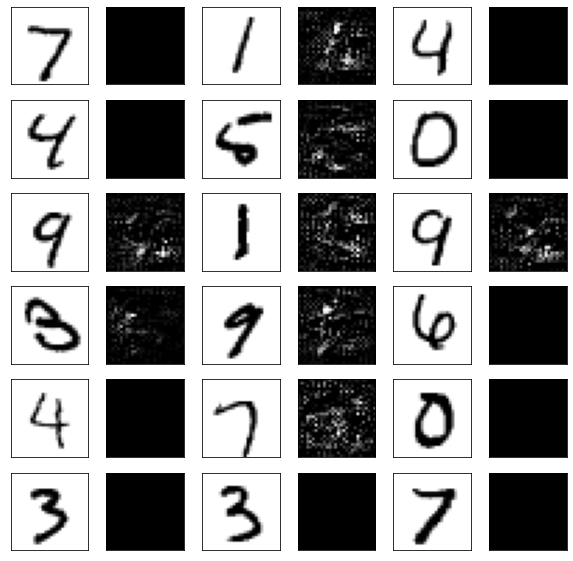

In [87]:
plot_figures(introspection_testing_images, masked_grads, num_images=36)

# Activation Maximization